<a href="https://colab.research.google.com/github/djbell01/563-DawsonBell/blob/main/Project2_DBell.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import hoomd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import freud
import gsd.hoomd
import os

In [221]:
class Simulation():
    def __init__(self,folder_name,T,dt=0.001,density=0.5,epsilon=1.0,sigma=1.0,unit_cell_replicas=20):
        self.folder_name = folder_name
        self.kBT = T # Assume kB = 1
        self.dt = dt
        self.density = density
        self.epsilon = epsilon
        self.sigma = sigma
        self.num_replicas = unit_cell_replicas

        device = hoomd.device.CPU()
        seed = np.random.randint(1,1e4)
        self.simulation = hoomd.Simulation(device = device, seed = seed)

        #a is the spacing between particles
        a = 1/(density**(1/3.0))
        #We want a number of particles N in our system.
        #Since we will be replicating the system in 3 dimensions, the number of unit cells we need is N^(1/3)
        N_particles = self.num_replicas**3
        grid_particles = freud.data.UnitCell([a,a,a,0,0,0],[[0,0,0]]).generate_system(self.num_replicas)
        self.box_length = grid_particles[0].Lx

        frame = gsd.hoomd.Frame()
        frame.particles.N = N_particles
        frame.particles.position = grid_particles[1]
        frame.configuration.box = [self.box_length,self.box_length,self.box_length,0,0,0]

        #Types of particles define different interactions. In an atomistic simulation these might be C, O, and H.
        #in a coarse-grained simulation we can give them a simple name like A
        frame.particles.typeid = [0]*N_particles
        frame.particles.types = ['A']

        os.mkdir(folder_name)

        #Finally, save our initial state:
        with gsd.hoomd.open(name=folder_name+'/initial_state.gsd', mode='w') as f:
            f.append(frame)

        self.simulation.create_state_from_gsd(filename=folder_name+'/initial_state.gsd')

        integrator = hoomd.md.Integrator(dt = dt)
        nvt = hoomd.md.methods.NVT(filter = hoomd.filter.All(),kT=self.kBT,tau=1.0)
        integrator.methods.append(nvt)

        cell = hoomd.md.nlist.Cell(buffer=0.4)

        #Define the force for different particles
        lj = hoomd.md.pair.LJ(nlist=cell)

        lj.params[('A', 'A')] = {"epsilon":epsilon, "sigma":sigma}

        lj.r_cut[('A', 'A')] = 2.5*sigma

        integrator.forces.append(lj)
        self.simulation.operations.integrator = integrator

        self.simulation.state.thermalize_particle_momenta(filter=hoomd.filter.All(), kT=self.kBT)
        thermodynamic_properties = hoomd.md.compute.ThermodynamicQuantities(
            filter=hoomd.filter.All()
        )

        self.simulation.operations.computes.append(thermodynamic_properties)
        logger = hoomd.logging.Logger(categories=['scalar'])
        logger.add(thermodynamic_properties, quantities=['potential_energy','kinetic_energy','pressure'])
        energy_table = hoomd.write.Table(trigger=hoomd.trigger.Periodic(period=int(1)), logger=logger, output=open(f'{folder_name}/dt_{str(dt)}.csv','w'))
        self.simulation.operations.writers.append(energy_table)


    def run(self,nsteps):
        self.simulation.run(nsteps)
        snapshot = self.simulation.state.get_snapshot()
        positions = snapshot.particles.position
        np.savetxt(f"{self.folder_name}/final_positions.txt", positions, delimiter=" ")

        with open(f'{self.folder_name}/parameters','w') as file:
             file.write(f'N_particles = {self.num_replicas**3}\n')
             file.write(f'N/V = {self.density}\n')
             file.write(f'Box length = {self.box_length}\n')
             file.write(f'kBT = {self.kBT}\n')
             file.write(f'Timestep = {self.dt}\n')
             file.write(f'Epsilon = {self.epsilon}\n')
             file.write(f'Sigma = {self.sigma}\n')
             file.write(f'Unit Cell Replicas = {self.num_replicas}')



# Independent functions
def plot_total_energy(file_name):
        df = pd.read_csv(file_name,sep='\s+')
        total_energy = (df['md.compute.ThermodynamicQuantities.potential_energy'] + df['md.compute.ThermodynamicQuantities.kinetic_energy']).to_numpy()

        plt.plot(total_energy)
        plt.xlabel('Timestep')
        plt.ylabel('Energy')
        plt.show()


def autocorr1D(array,equilibration_time):
    array = array[equilibration_time:]
    ft = np.fft.rfft(array - np.average(array))
    acorr = np.fft.irfft(ft * np.conjugate(ft)) / (len(array) * np.var(array))
    decorr_time = np.where(acorr<0)[0][0]
    return decorr_time


def heat_capacity(energy_array,temperature,equilibration_length):
        decorr_time = autocorr1D(energy_array,equilibration_length)

        samples = energy_array[equilibration_length::decorr_time]
        samples_squared = samples**2

        return (np.mean(samples)**2 + np.mean(samples_squared))/(temperature**2)


def pbc(d, L):
    return np.where(d > L / 2, d - L, np.where(d <= -L / 2, d + L, d))


def rdf(file_name, box_length, density):
    positions = np.loadtxt(file_name)
    num_particles = len(positions)
    max_radius = box_length / 2
    num_bins = 1000
    bin_edges = np.linspace(0, max_radius, num_bins + 1)
    hist = np.zeros(num_bins)

    for i in range(num_particles):
        diff = positions - positions[i]
        diff = pbc(diff, box_length)
        distances = np.linalg.norm(diff, axis=1)
        distances = distances[distances > 0]  # Exclude self-interaction
        hist += np.histogram(distances, bins=bin_edges)[0]

    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    volumes = (4 / 3) * np.pi * (bin_edges[1:]**3 - bin_edges[:-1]**3)
    normalized_hist = hist / (volumes * density * num_particles)
    return bin_centers, normalized_hist

#### 1. Characterize your model's behavior at N/V = 0.5 in the NVT ensemble.
a. Above what temperature is your system "hot"? How do you know?<br>
b. Below what temperature is your system "frozen"? How do you know?<br>
c. How does the system's total energy, potential energy, kinetic energy, heat capacity, and structure vary from frozen to too hot?<br>

In [ ]:
# In hind sight, I don't know why I did more steps for the hotter simulations. My thought was
# that the colder ones should aggregate more quickly, but clearly their equilibration will be slower.

T_01 = Simulation('T_0.1',T=0.1)
T_01.run(500000)

T_05 = Simulation('T_0.5',T=0.5)
T_05.run(500000)

T_1 = Simulation('T_1.0',T=1.0)
T_1.run(500000)

T_5 = Simulation('T_5.0',T=5.0)
T_5.run(1000000)

T_10 = Simulation('T_10.0',T=10.0)
T_10.run(1000000)

In [147]:
default_box_length = 25.198421478271484
default_density = 0.5

In [ ]:
# Note: I had to calculate rdfs in separate cells. Running a loop for some reason leads to an error.
# I have to re-run the cell that defines the rdf function between each calculation. I'm not sure what is causing
# this bug, unfortunately, but that is the reasoning for this sub-optimal code structure.

bins,hist = rdf('T_0.1/final_positions.txt',default_box_length,default_density)
rdf = np.array([bins,hist])
np.savetxt("T_0.1/rdf.txt", rdf.T, delimiter=" ")

In [ ]:
bins,hist = rdf('T_0.5/final_positions.txt',default_box_length,default_density)
rdf = np.array([bins,hist])
np.savetxt("T_0.5/rdf.txt", rdf.T, delimiter=" ")

In [148]:
bins,hist = rdf('T_1.0/final_positions.txt',default_box_length,default_density)
rdf = np.array([bins,hist])
np.savetxt("T_1.0/rdf.txt", rdf.T, delimiter=" ")

In [151]:
bins,hist = rdf('T_5.0/final_positions.txt',default_box_length,default_density)
rdf = np.array([bins,hist])
np.savetxt("T_5.0/rdf.txt", rdf.T, delimiter=" ")

In [154]:
bins,hist = rdf('T_10.0/final_positions.txt',default_box_length,default_density)
rdf = np.array([bins,hist])
np.savetxt("T_10.0/rdf.txt", rdf.T, delimiter=" ")

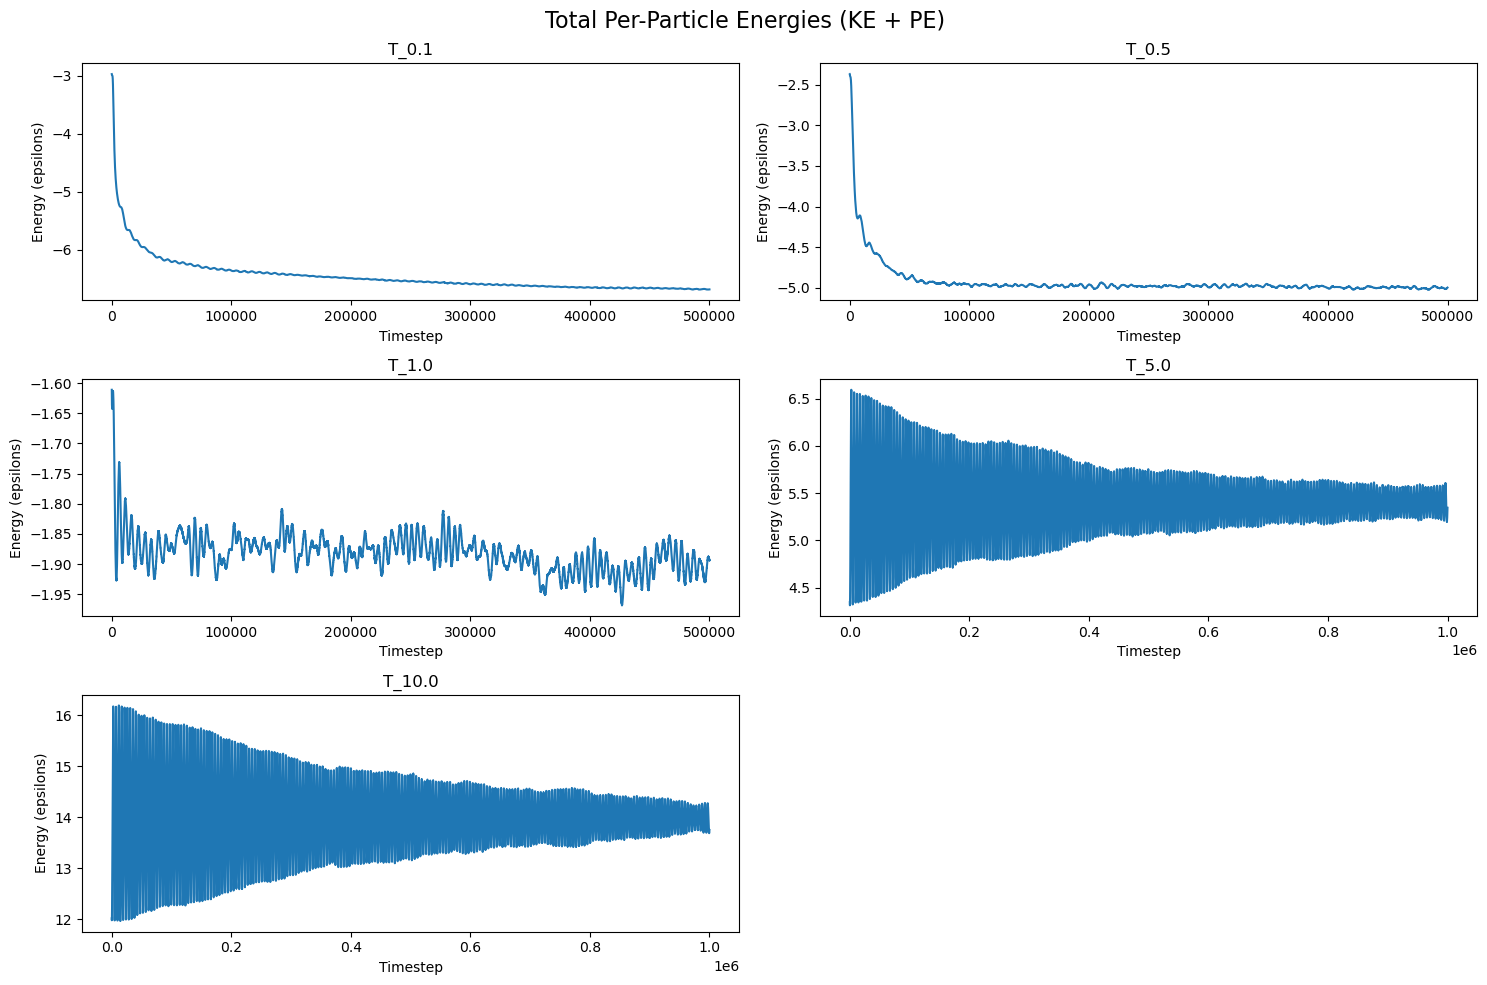

In [176]:
file_list = ['T_0.1','T_0.5','T_1.0','T_5.0','T_10.0']

axes = [None] * 5
fig = plt.figure(figsize=(15,10))
for i,file in enumerate(file_list):
    df = pd.read_csv(f'{file}/dt_0.001.csv',skiprows=1,names=('PE','KE'),sep='\s+')
    total_energy = (df['PE']+df['KE']).to_numpy()
    per_particle_energy = total_energy/8000
    axes[i] = fig.add_subplot(3,2,i+1)
    axes[i].plot(per_particle_energy)
    axes[i].set_title(file)
    axes[i].set_ylabel('Energy (epsilons)')
    axes[i].set_xlabel('Timestep')
fig.suptitle('Total Per-Particle Energies (KE + PE)',fontsize='16')
fig.tight_layout()
plt.show()

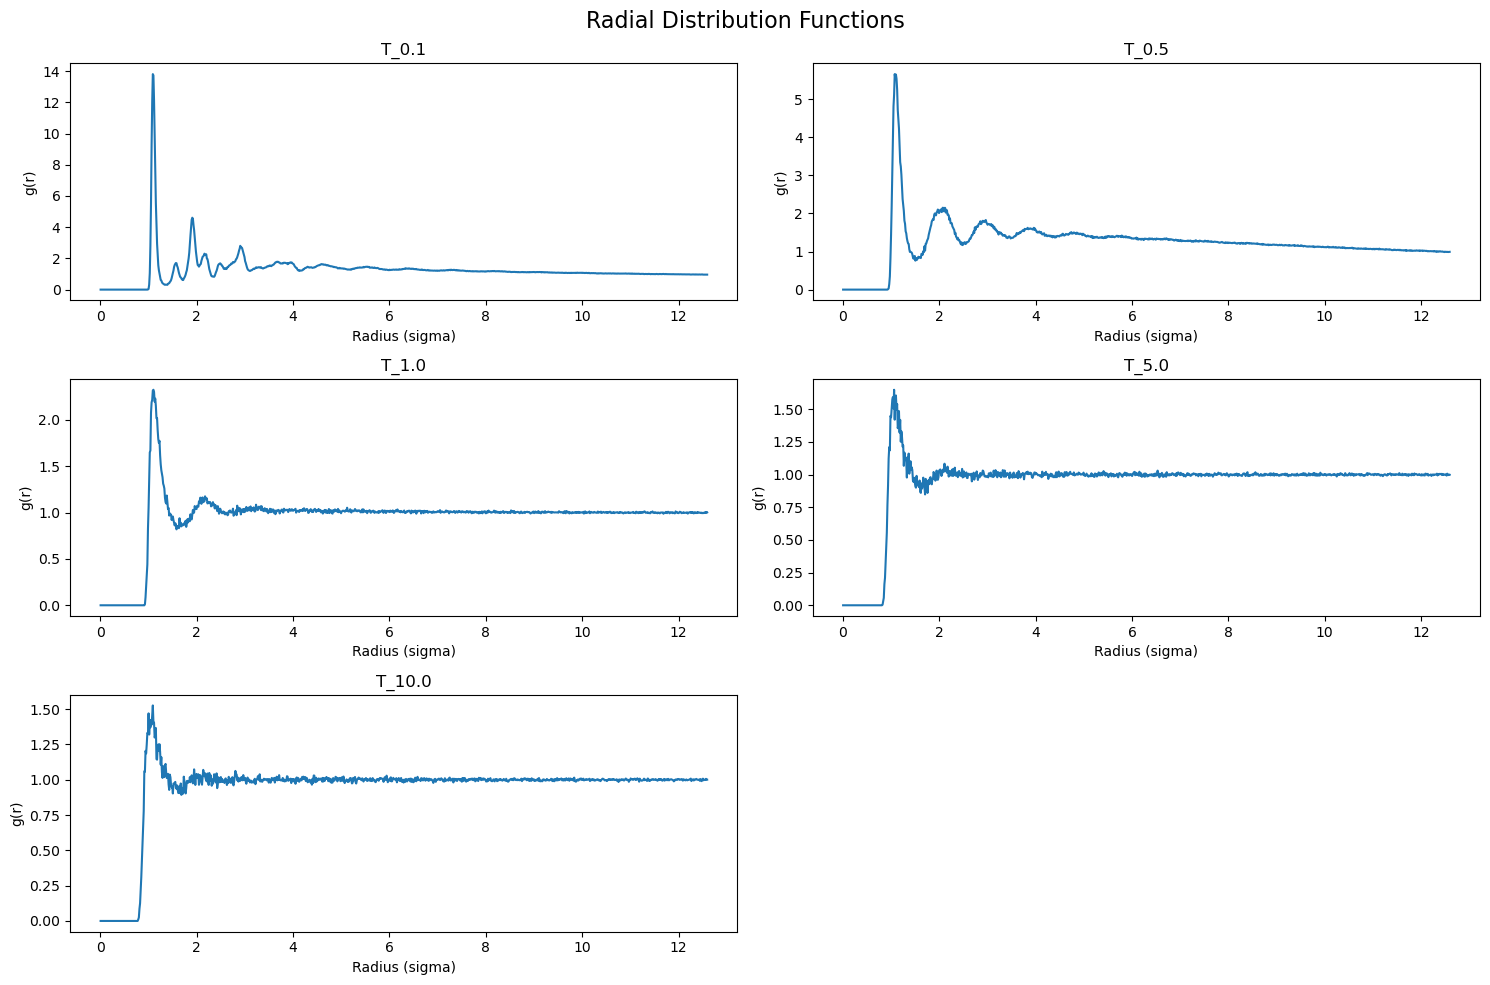

In [ ]:
axes = [None] * 5
fig = plt.figure(figsize=(15,10))
for i,file in enumerate(file_list):
    df = pd.read_csv(f'{file}/rdf.txt',names=('bins','freq'),sep=None,engine='python')
    axes[i] = fig.add_subplot(3,2,i+1)
    axes[i].plot(df['bins'],df['freq'])
    axes[i].set_title(file)
    axes[i].set_ylabel('g(r)')
    axes[i].set_xlabel('Radius (sigma)')
fig.suptitle('Radial Distribution Functions',fontsize='16')
fig.tight_layout()
plt.show()

In [190]:
# Calculate average E, PE, KE, and heat capacity
temps = [0.1,0.5,1.0,5.0,10.0]
pes = []
kes = []
tes = []
hcs = []

for i,file in enumerate(file_list):
    df = pd.read_csv(f'{file}/dt_0.001.csv',skiprows=1,names=('PE','KE'),sep='\s+')
    pe_traj = df['PE'].to_numpy()/8000
    ke_traj = df['KE'].to_numpy()/8000
    te_traj = ke_traj + pe_traj
    
    decorr_pe = autocorr1D(pe_traj,100000)
    pe_samples = pe_traj[100000::decorr_pe]
    pes.append(np.mean(pe_samples))

    decorr_ke = autocorr1D(ke_traj,100000)
    ke_samples = ke_traj[100000::decorr_ke]
    kes.append(np.mean(ke_samples))

    decorr_te = autocorr1D(te_traj,100000)
    te_samples = te_traj[100000::decorr_te]
    tes.append(np.mean(te_samples))

    hc = heat_capacity(te_traj,temps[i],100000)
    hcs.append(hc)

table = pd.DataFrame({'kBT' : temps,
                      'PE' : pes,
                      'KE' : kes,
                      'Total Energy' : tes,
                      'Heat Capacity' : hcs})

table
    

,kBT,PE,KE,Total Energy,Heat Capacity
0,0.1,-6.685958,0.149879,-6.535041,8542.536027
1,0.5,-5.724908,0.749687,-4.973187,197.861437
2,1.0,-3.383508,1.499849,-1.878598,7.058720
3,5.0,-2.096123,7.497904,5.401807,2.337837
4,10.0,-1.010570,14.996287,13.986709,3.916863


Based on the RDFs shown, my system is frozen at a reduced temperature of 0.1. At 0.5, the perfect crystalline lattice has broken down, but there is still a very high amount of structure, with peaks visible as far as 5 or 6 times 1.12 $\sigma$, indicating liquid phase where the average distance between particles is very consistent. At a temp of 1.0 the RDF is beginning to resemble a much faster moving fluid, akin to what might be a gas if the volume was not fixed. Certainly at a temperature of 5.0 the system has reached a gas-like state, however the fact that the energy is oscillating about a single value indicates to me that the temperature coupling is too strong for this high of a temperature, which may be causing artifacts in the simulation. Nevertheless, the RDFs of T = 5.0 and T = 10.0 nicely follow the trend of decreasing structure.

#### 2. Characterize finite size effects.
a. How small is too small to be correct? How large is too large to be practical?

In [ ]:
# I chose to simulate at t = 0.1 because finite size effects should be more prevalent for aggregated/frozen systems.

N_125 = Simulation('N_125',T=0.1,unit_cell_replicas=5)
N_125.run(500000)

N_512 = Simulation('N_512',T=0.1,unit_cell_replicas=8)
N_512.run(500000)

N_1000 = Simulation('N_1000',T=0.1,unit_cell_replicas=10)
N_1000.run(500000)

N_2197 = Simulation('N_2197',T=0.1,unit_cell_replicas=13)
N_2197.run(500000)

N_4096 = Simulation('N_4096',T=0.1,unit_cell_replicas=16)
N_4096.run(500000)

In [191]:
def calc_energy(filename,num_particles,equilibration_time):
    df = pd.read_csv(filename,skiprows=1,names=('PE','KE'),sep='\s+')
    total_energy = (df['PE']+df['KE']).to_numpy()/num_particles
    decorr = autocorr1D(total_energy,equilibration_time)
    samples = total_energy[equilibration_time::decorr]
    return np.mean(samples),np.std(samples)

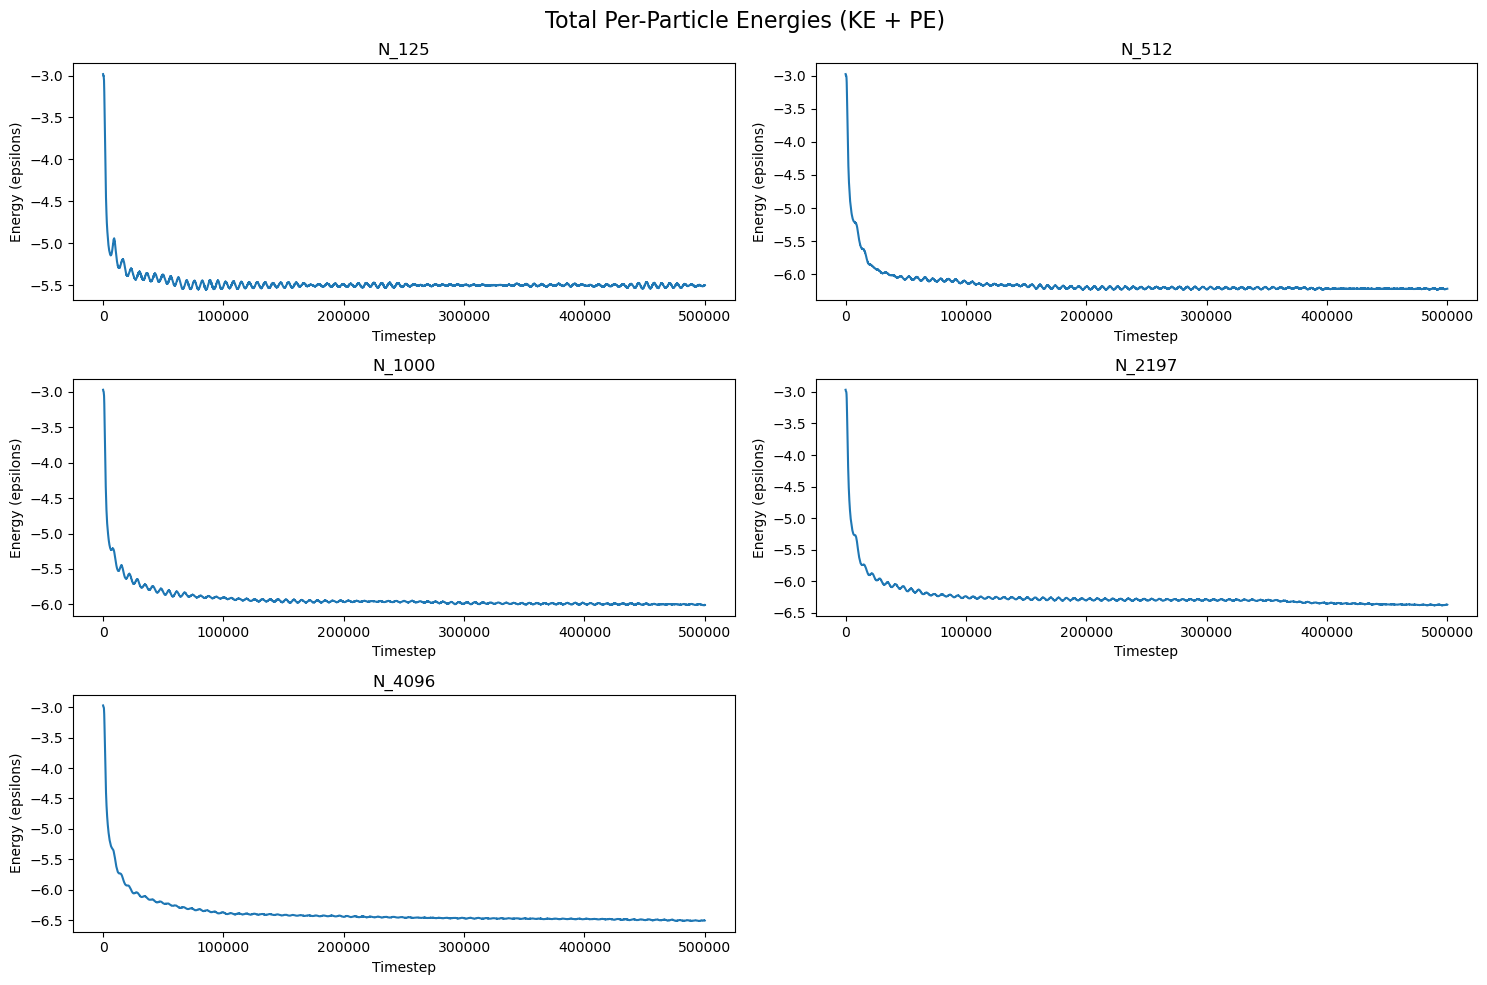

In [210]:
file_list = ['N_125','N_512','N_1000','N_2197','N_4096']
n_list = [125,512,1000,2197,4096]

axes = [None] * 5
fig = plt.figure(figsize=(15,10))
for i,file in enumerate(file_list):
    df = pd.read_csv(f'{file}/dt_0.001.csv',skiprows=1,names=('PE','KE'),sep='\s+')
    total_energy = (df['PE']+df['KE']).to_numpy()
    per_particle_energy = total_energy/n_list[i]
    axes[i] = fig.add_subplot(3,2,i+1)
    axes[i].plot(per_particle_energy)
    axes[i].set_title(file)
    axes[i].set_ylabel('Energy (epsilons)')
    axes[i].set_xlabel('Timestep')
fig.suptitle('Total Per-Particle Energies (KE + PE)',fontsize='16')
fig.tight_layout()
plt.show()

In [ ]:
energy = [None] * 6
std = [None] * 6

energy[0],std[0] = calc_energy('N_125/dt_0.001.csv',125,100000)
print(f'N = 125; Energy = {energy[0]} +/- {std[0]}')

energy[1],std[1] = calc_energy('N_512/dt_0.001.csv',512,100000)
print(f'N = 512; Energy = {energy[1]} +/- {std[1]}')

energy[2],std[2] = calc_energy('N_1000/dt_0.001.csv',1000,100000)
print(f'N = 1000; Energy = {energy[2]} +/- {std[2]}')

energy[3],std[3] = calc_energy('N_2197/dt_0.001.csv',2197,100000)
print(f'N = 2197; Energy = {energy[3]} +/- {std[3]}')

energy[4],std[4] = calc_energy('N_4096/dt_0.001.csv',4096,100000)
print(f'N = 4096; Energy = {energy[4]} +/- {std[4]}')

energy[5],std[5] = calc_energy('T_0.1/dt_0.001.csv',8000,100000)
print(f'N = 8000; Energy = {energy[5]} +/- {std[5]}')

N = 125; Energy = -5.498198647 +/- 0.015333393840581308
N = 512; Energy = -6.197851574218751 +/- 0.034179879852175465
N = 1000; Energy = -5.96486909 +/- 0.034023941949919166
N = 2197; Energy = -6.304197492034593 +/- 0.04223604740986428
N = 4096; Energy = -6.454803584798178 +/- 0.044576624156617374
N = 8000; Energy = -6.535040951249999 +/- 0.10881083495003219


In [211]:
n_list.append(8000)

Text(0.5, 0, 'Number of Particles in Simulation Box')

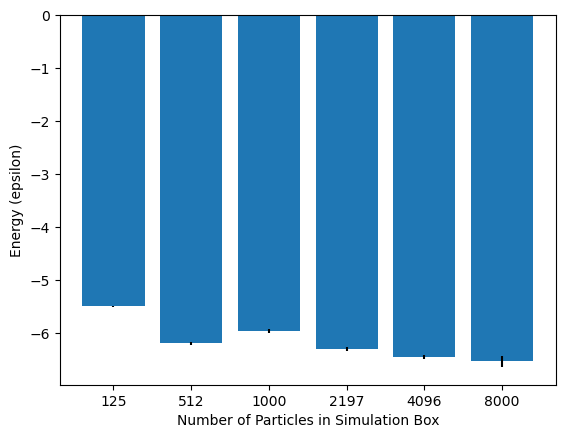

In [217]:
labels = [str(n) for n in n_list]
plt.bar(labels,energy,yerr=std)
plt.ylabel('Energy (epsilon)')
plt.xlabel('Number of Particles in Simulation Box')

Systems of 1000 or fewer particles converge to different energies than larger systems. Of the values tested, N of 2197, 4096, and 8000 had reasonable agreement, though N=2197 still fell outside of the standard deviation of the N=8000 run. Based on these results, I will run my further simulations with 4096 particles ($16^{3}$ unit cells) to balance efficiency and accuracy.

#### 3. Contrast your system with an ideal gas.<br>
a. How does the structure of your model vary with state, and how does it compare to particles with no interactions?<br>
b. Does the heat capacity of your system depend on state differently than an ideal gas?<br>
c. Can you derive or numerically determine an equation of state?

In [223]:
T_0_1P = Simulation('T_0.1_P',0.1,unit_cell_replicas=16)
T_0_1P.run(500000)

T_0_5P = Simulation('T_0.5_P',0.5,unit_cell_replicas=16)
T_0_5P.run(500000)

T_1_0P = Simulation('T_1.0_P',1.0,unit_cell_replicas=16)
T_1_0P.run(500000)

T_1_5P = Simulation('T_1.5_P',1.5,unit_cell_replicas=16)
T_1_5P.run(500000)

T_2_0P = Simulation('T_2.0_P',2.0,unit_cell_replicas=16)
T_2_0P.run(500000)

/home/dawson/anaconda3/envs/563-project/lib/python3.11/site-packages/hoomd/md/methods/methods.py:102: FutureWarning: NVT is deprecated and wil be removed in hoomd 4.0. In version 4.0, use the ConstantVolume method with the desired thermostat from hoomd.md.methods.thermostats.
  warnings.warn(


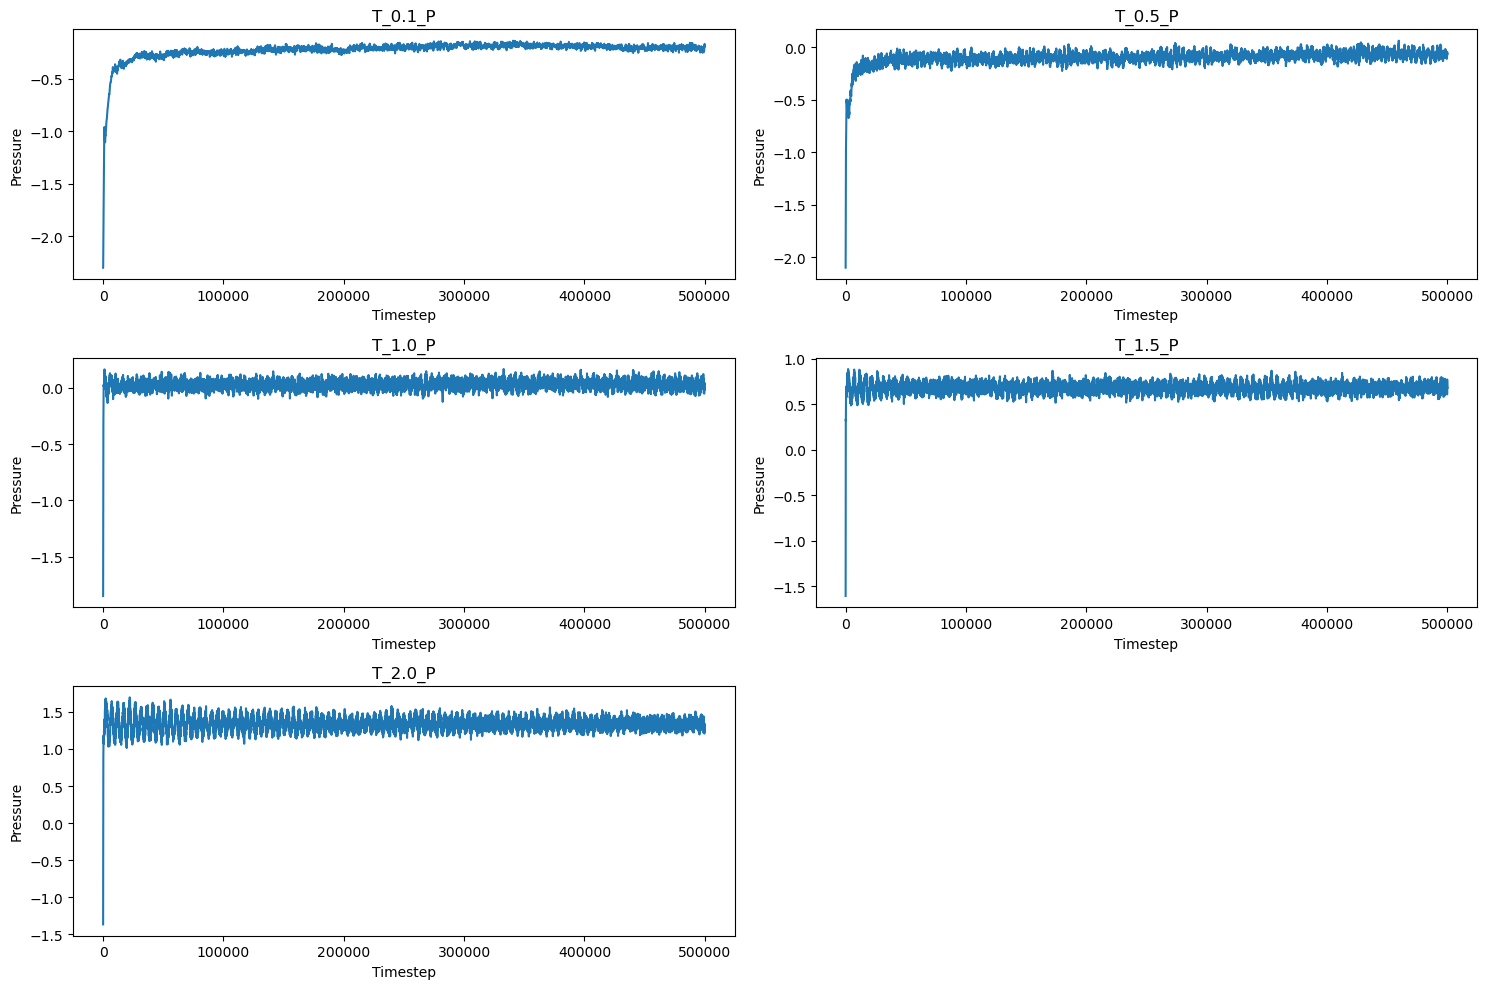

In [225]:
file_list = ['T_0.1_P','T_0.5_P','T_1.0_P','T_1.5_P','T_2.0_P']

axes = [None] * 5
fig = plt.figure(figsize=(15,10))
for i,file in enumerate(file_list):
    df = pd.read_csv(f'{file}/dt_0.001.csv',skiprows=1,names=('PE','KE','Pressure'),sep='\s+')
    axes[i] = fig.add_subplot(3,2,i+1)
    axes[i].plot(df['Pressure'])
    axes[i].set_title(file)
    axes[i].set_ylabel('Pressure')
    axes[i].set_xlabel('Timestep')
fig.tight_layout()
plt.show()

In [229]:
temps = [0.1,0.5,1.0,1.5,2.0]
pressures = []
stds = []

for file in file_list:
    df = pd.read_csv(f'{file}/dt_0.001.csv',skiprows=1,names=('PE','KE','Pressure'),sep='\s+')
    pressure = df['Pressure'].to_numpy()
    decorr = autocorr1D(pressure,100000)
    samples = pressure[100000::decorr]
    pressures.append(np.mean(samples))
    stds.append(np.std(samples))
    

Text(0.5, 1.0, 'Simulation State Points vs Ideal Gas')

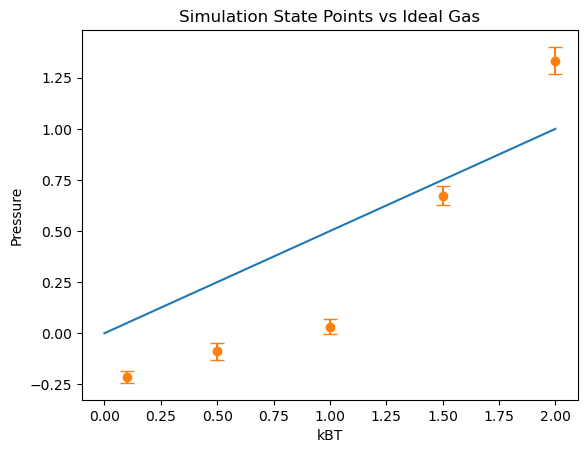

In [237]:
def ideal_gas(T):
    return 0.5*T # 0.5 is density of all systems

x_vals = np.linspace(0,2.0,1000)
y_vals = ideal_gas(x_vals)

plt.plot(x_vals,y_vals)
plt.errorbar(temps,pressures,yerr=stds,fmt='o',capsize=5)
plt.xlabel("kBT")
plt.ylabel("Pressure")
plt.title('Simulation State Points vs Ideal Gas')

Text(0, 0.5, 'Heat Capacity')

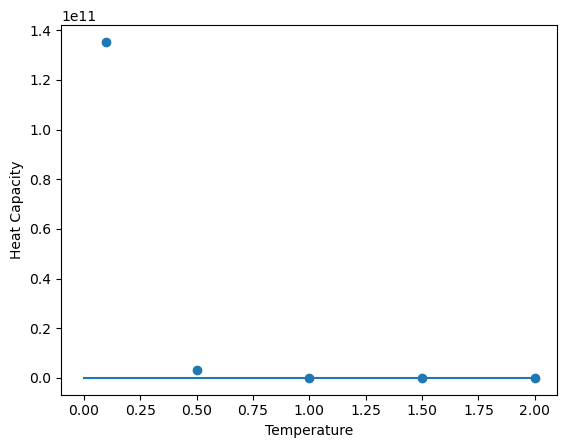

In [239]:
x_vals = np.linspace(0,2.0,1000)
y_vals = np.ones_like(x_vals) * (3/2)

heat_capacities = []

for i,file in enumerate(file_list):
    df = pd.read_csv(f'{file}/dt_0.001.csv',skiprows=1,names=('PE','KE','Pressure'),sep='\s+')
    total_energy = (df['PE']+df['KE']).to_numpy()
    hc = heat_capacity(total_energy,temps[i],100000)
    heat_capacities.append(hc)

plt.plot(x_vals,y_vals)
plt.scatter(temps,heat_capacities)
plt.xlabel('Temperature')
plt.ylabel('Heat Capacity')
    

In this model, the pressure dependence on temperature is not linear.

The heat capacity seems to diverge greatly from that of an ideal gas at low temperatures. This makes sense, because at low temperature the interactions between particles will be the most dominant.

#### 4. Summarize your observations, challenges, and any revelations you had while working towards 1-3. Which specific simulation and state point was your favorite and why?

My biggest challenge with this project was struggling to find a way to check my answers. I do not have any physical intuition for what a correct heat capacity might look like for Lennard-Jones spheres, and I don't know what reasonable energies look like. The best I could do was to compare to my classmates. I think I really need to gain a better working knowledge of statistical mechanics to make reasonable conclusions.

One problem I encountered that ended up being quite rewarding to figure out was computing the heat capacity. From the equation we derived in the last homework, I knew I needed to divide by a factor of $k_{B}T^{2}$. This confused me, because the software takes in $k_{B}T$ as one value, so I didn't understand how to find $T^{2}$. Kaden and I talked about this, and he had the idea that if we assume $k_{B} = 1$, then you can simply divide by $T^{2}$, and then your temperatures will all be in units of $k_{B}$. It's interesting to note that, if $k_{B} = 1$ and $\epsilon = 1$, then $k_{B}$ and $\epsilon$ units become interchangeable. Reduced units are still difficult for me to fully wrap my head around, but I'm starting to really see their usefullness.

My favorite state point was at T=0.5, because it had an amazing radial distribution curve where you could see so many equidistant peaks corresponding to multiples of 1.12 $\sigma$.